In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import hydroeval as he
import datetime

from InterpolateHelperFunctions import *

all_pressure_df = pd.read_csv("all_pressure.csv")

In [24]:
# site_id = "BSL"
# site_df = pd.DataFrame()
# site_df[["datetime","pressure_hobo"]] = all_pressure_df[["datetime",site_id]]
# site_df['datetime'] = pd.to_datetime(site_df['datetime'], format='%Y-%m-%d %H:%M:%S')
# site_df = site_df[site_df['pressure_hobo'].notna()]
# all_days = pd.date_range(site_df['datetime'].min(), site_df['datetime'].max(), freq='15min')
# all_days = pd.DataFrame(all_days, columns=["datetime"])
# site_df = all_days.merge(site_df, on='datetime', how='left')

# #generating a test dataframe from our actual data. This function generate randomly indexed sequences of nas of random lengths
# test_df = get_test_df(site_df)

In [1]:
#site_names_list = ['BLI']
site_names_list = ['BEN', 'BLI', 'BSL', 'CLE', 'CRB', 'DAI', 'DFF', 'DFL', 'DFM', 'DFU', 'HCL', 'HCN', 'HCS', 'IND', 'LAK', 'LDF', 'MIT', 'NEB', 'PBC', 'SBL', 'SFL', 'SHE', 'SHE_', 'SOL', 'SOL_', 'STR', 'TCU', 'TIE', 'WAN']
matrix_size_list = [1000,2000,3000,4000]
mv_avg_width_list = [300,500,750,1000]

In [ ]:
metrics_list = []
#iterate through each site
for site_id in site_names_list:
    print(f"Working on site: {site_id}")
    
    try:
        
        site_df = pd.DataFrame()
        site_df[["datetime","pressure_hobo"]] = all_pressure_df[["datetime",site_id]]
        site_df['datetime'] = pd.to_datetime(site_df['datetime'], format='%Y-%m-%d %H:%M:%S')
        site_df = site_df[site_df['pressure_hobo'].notna()]
        all_days = pd.date_range(site_df['datetime'].min(), site_df['datetime'].max(), freq='15min')
        all_days = pd.DataFrame(all_days, columns=["datetime"])
        site_df = all_days.merge(site_df, on='datetime', how='left')

        #generating a test dataframe from our actual data. This function generate randomly indexed sequences of nas of random lengths
        test_df = get_test_df(site_df)

        #iterate through different potential down sample values
        for matrix_size in matrix_size_list:

            sparse_joined_df = down_sample_and_interpolate_once(test_df,all_days,matrix_size,1,'pressure_hobo')

            #iterate through different potential moving average window widths
            for window_width in mv_avg_width_list:

                #print(f"Attempting width: {window_width}")
                
                # creating rolling average column that will fill in gaps left by down sampling
                sparse_joined_df["rolling_average"] = sparse_joined_df["pressure_combined"].rolling(min_periods=1, center=True, window=window_width).mean()

                #merging the actual, interpolated, and rolling average columns
                sparse_joined_df['pressure_combined_filled'] = sparse_joined_df.apply(combine_pressure_row, axis=1)

                sample_down_to = int(test_df.shape[0]/(2*matrix_size + 1))

                #finding hydro eval metrics for the current hyperparameters
                filled_test_df = sparse_joined_df
                my_nse = he.evaluator(he.nse, filled_test_df["pressure_combined_filled"], site_df["pressure_hobo"])
                my_pbias = he.evaluator(he.pbias, filled_test_df["pressure_combined_filled"], site_df["pressure_hobo"])
                my_rmse = he.evaluator(he.rmse, filled_test_df["pressure_combined_filled"], site_df["pressure_hobo"])
                
                #add metrics and identifiers to a list of dictionaries
                metrics_dict = (site_id, sample_down_to, matrix_size, window_width, my_nse, my_pbias, my_rmse)
                metrics_list.append(metrics_dict)

                #saving each individual df, unrealistic when testing a lot of hyperparameters
                #exec(f'{site_id}_{matrix_size}_{window_width}_filled_df = filled_test_df.copy()')

    except Exception as e: print(e)

#transform metrics list into dataframe
metrics_df = pd.DataFrame(metrics_list, columns=["site","sample_down_to","matrix_size","mv_avg_width","nse","pbias","rmse"])
metrics_df

In [ ]:
# print(BLI_2000_200_filled_df.isna().sum()/BLI_2000_200_filled_df.shape[0])

# plt.scatter(x = "datetime", y = "pressure_combined_filled",data=BLI_2000_200_filled_df, label="Completely Filled Data", s = .5, color="#723cba")
# plt.scatter(x = "datetime", y = "pressure_filled",data=BLI_2000_200_filled_df, label="Sparse Filled Data", s = .5, color="#3bb892")
# plt.scatter(x = "datetime", y = "pressure_hobo",data=BLI_2000_200_filled_df, label="Actual Data", s = .5, color="#224dab")

# left = datetime.date(2019, 8, 1)
# right = datetime.date(2019, 8, 2)
# # # Format the date into months & days
# # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %y')) 
# # Changes x-axis range
# plt.gca().set_xbound(left, right)
# plt.legend()
# plt.show()

In [5]:
#exporting metrics df as a csv
metrics_df.to_csv("model_selection_metrics.csv")

#fixing type for the metrics columns
metrics_df['nse'] = pd.to_numeric(metrics_df['nse'].str[0])
metrics_df['pbias'] = pd.to_numeric(metrics_df['pbias'].str[0])
metrics_df['rmse'] = pd.to_numeric(metrics_df['rmse'].str[0])

#the closer to 0 the better for percent bias, so taking the absolute value and then finding the minimum works here
metrics_df['pbias_abs'] = metrics_df['pbias'].abs()

#making a dataframe for each metric that shows which parameters resulted in the best score for each site
nse_maxs_df = metrics_df.loc[metrics_df.groupby('site')['nse'].idxmax().values]
pbias_mins_df = metrics_df.loc[metrics_df.groupby('site')['pbias_abs'].idxmin().values]
rmse_mins_df = metrics_df.loc[metrics_df.groupby('site')['rmse'].idxmin().values]

KeyboardInterrupt: 

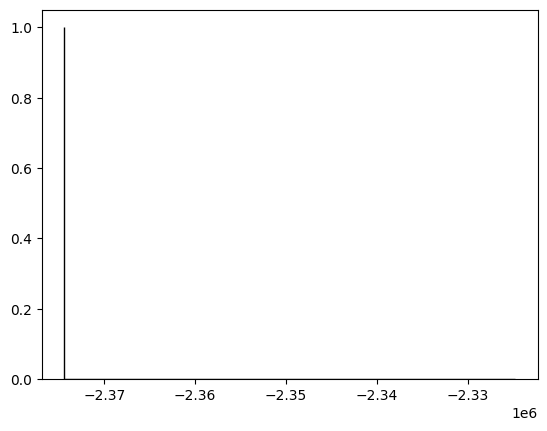

In [19]:
sns.histplot(x="nse",data=nse_maxs_df)

<Axes: xlabel='rmse', ylabel='Count'>

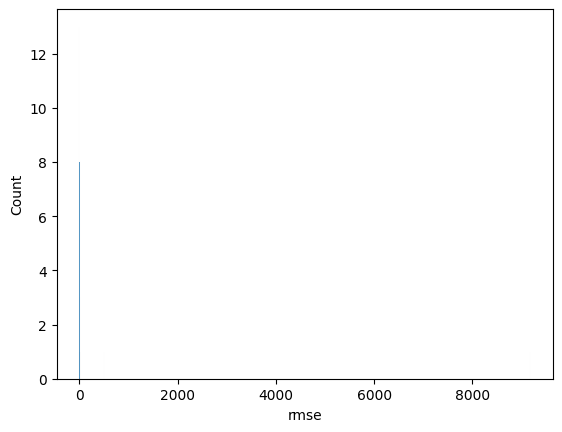

In [8]:
sns.histplot(x="rmse",data=rmse_mins_df)

<Axes: xlabel='pbias_abs', ylabel='Count'>

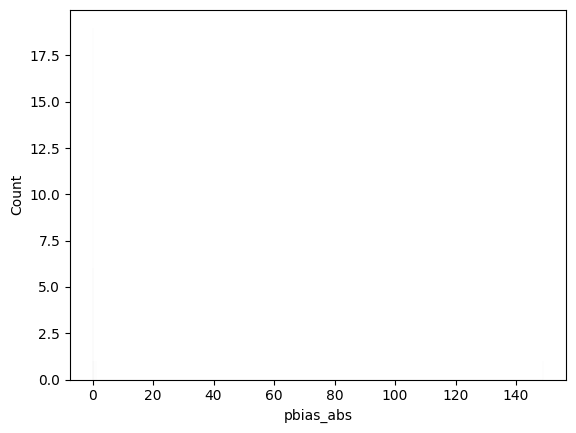

In [9]:
sns.histplot(x="pbias_abs",data=pbias_mins_df)

In [10]:
nse_maxs_df.to_csv("parameters_max_nse.csv")
nse_maxs_df

,site,sample_down_to,matrix_size,mv_avg_width,nse,pbias,rmse,pbias_abs
3,BEN,42,1000,1000,6.660660e-01,0.074772,3.526755,0.074772
17,BLI,29,1000,500,6.057259e-01,-0.021964,3.366582,0.021964
37,BSL,39,2000,500,8.757774e-01,-0.102413,5.667080,0.102413
53,CLE,32,2000,500,7.929524e-01,-0.066207,4.146129,0.066207
71,CRB,24,2000,1000,4.077253e-01,0.023486,6.107444,0.023486
83,DAI,27,1000,1000,6.785204e-01,0.119654,5.398861,0.119654
99,DFF,68,1000,1000,7.959190e-01,0.057425,4.292822,0.057425
115,DFL,24,1000,1000,-2.374399e+06,172.151135,9181.151955,172.151135
118,DFM,44,1000,750,5.878430e-01,-0.033162,3.856992,0.033162
133,DFU,28,1000,500,8.260814e-01,-0.099028,3.663872,0.099028


<Axes: xlabel='mv_avg_width', ylabel='nse'>

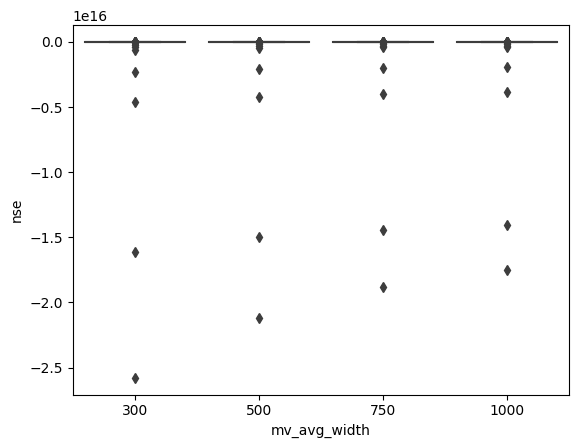

In [14]:
sns.boxplot(y="nse",x="mv_avg_width",data=metrics_df)

<Axes: xlabel='mv_avg_width', ylabel='rmse'>

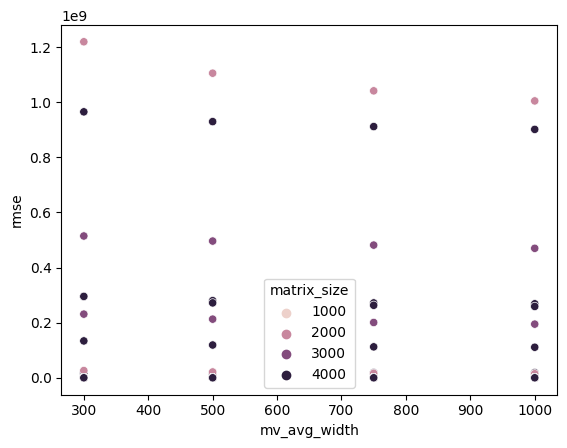

In [13]:
sns.scatterplot(y="rmse",x="mv_avg_width",hue="matrix_size",data=metrics_df)

<Axes: xlabel='mv_avg_width', ylabel='nse'>

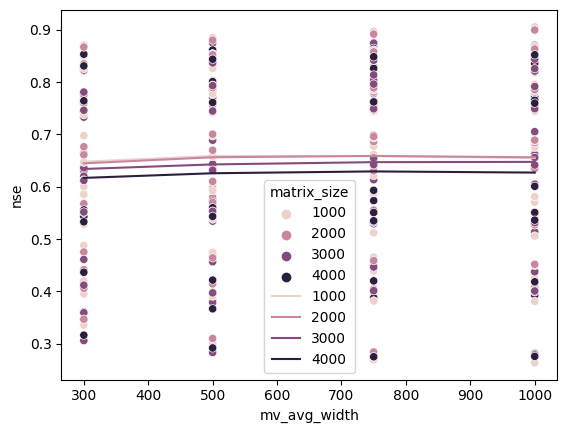

In [15]:

sns.scatterplot(y="nse",x="mv_avg_width",hue="matrix_size",data=metrics_df[metrics_df.nse > 0])
sns.lineplot(y="nse",x="mv_avg_width",hue="matrix_size",errorbar = None,data=metrics_df[metrics_df.nse > 0])

<Axes: xlabel='sample_down_to', ylabel='nse'>

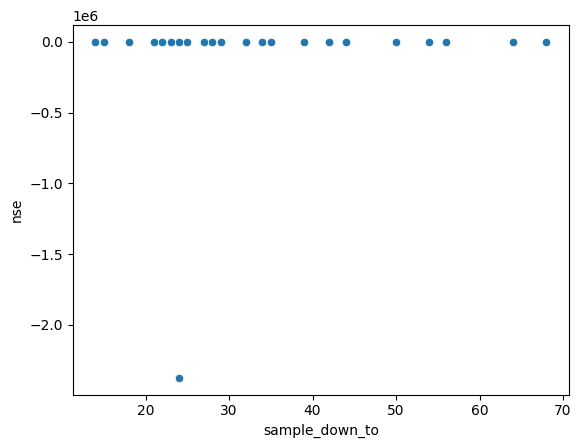

In [16]:
sns.scatterplot(x="sample_down_to",y="nse",data=nse_maxs_df)

<Axes: xlabel='matrix_size', ylabel='nse'>

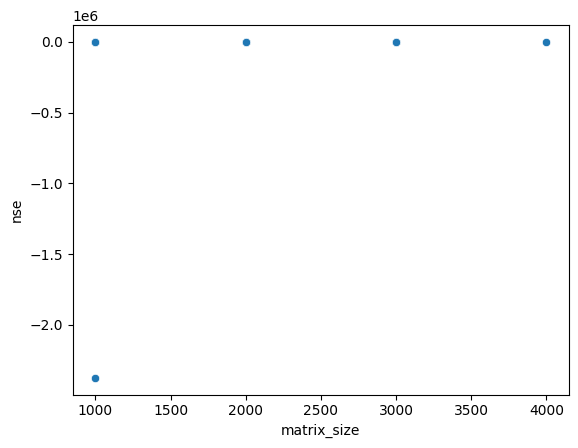

In [17]:
sns.scatterplot(x="matrix_size",y="nse",data=nse_maxs_df)

<Axes: xlabel='pbias', ylabel='nse'>

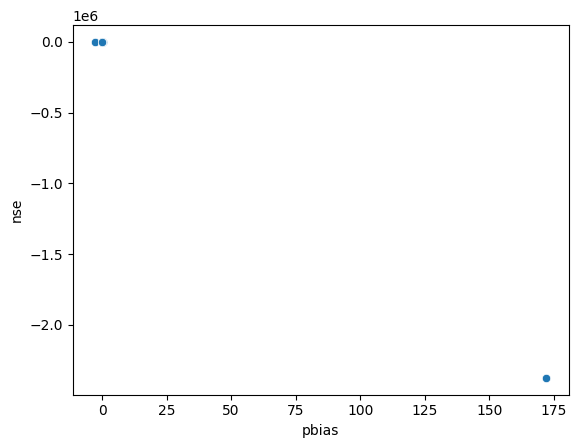

In [18]:
sns.scatterplot(x="pbias",y="nse",data=nse_maxs_df)

<Axes: xlabel='sample_down_to', ylabel='matrix_size'>

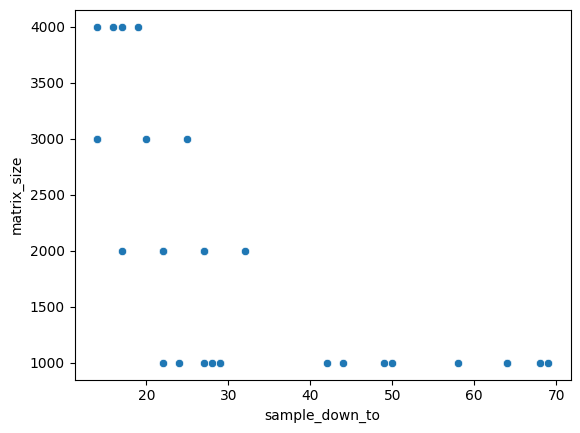

In [92]:
sns.scatterplot(x="sample_down_to",y="matrix_size",data=nse_maxs_df)